In [1]:
import tensorflow as tf
import os
import time
import glob
from matplotlib import pyplot as plt
from IPython import display
import numpy as np
import datetime

## Variables

In [2]:
train_path = "/storage/ziaeea21/projects/Prostate_Segmentation/data/Train"
checkpoint_dir = './training_checkpoints'
log_dir = "./logs/"

BUFFER_SIZE = 400
BATCH_SIZE = 1
NUM_CLASSES = 5
LAMBDA = 100
EPOCHS = 20

## Load and Prepare the dataset

In [3]:
def get_path_list(dataset_path, typ = '*.png'):
    
    img_path_list = glob.glob(dataset_path + "/images/" + typ)
    label_path_list = glob.glob(dataset_path + "/labels/"  + typ)
    assert len(img_path_list) == len(label_path_list) , 'The length of two list should be same'

    label_path_list.sort()
    img_path_list.sort()
    assert (img_path_list[i].endswith(label_path_list[i].split('/')[-1]) for i in range(len(img_path_list))) , 'There is a mismatching name'
    
    return img_path_list, label_path_list    

In [4]:
def load(image_file, label_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    label = tf.io.read_file(label_file)
    label = tf.image.decode_jpeg(label)

    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.uint8)

    return image, label

In [5]:
def normalize(image, label):
    # normalizing the images to [-1, 1]
    
    image = tf.image.per_image_standardization(image)
    #image = (image / 127.5) - 1
    #label = (label / 127.5) - 1

    return image, label

In [6]:
@tf.function()
def random_augmentation(image, label):
    
    #if tf.random.uniform(()) > 0.5:
    #    image = tf.image.random_brightness(image, max_delta=.50)
        
    #if tf.random.uniform(()) > 0.5:
    #    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
        
    #if tf.random.uniform(()) > 0.5:
     #   image = tf.image.random_hue(image, max_delta=0.2)
        
   # if tf.random.uniform(()) > 0.5:
     #   image = tf.image.random_contrast(image, lower=0.1, upper=.8)
    
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
        

        
    return image, label

In [7]:
def show_img(img,label, n_classes):
    img = img[0,:,:,:]
    label = label[0,:,:,:]

    plt.imshow(img)
    fig, axs = plt.subplots(1,n_classes, figsize=(15, 6), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(n_classes):
        axs[i].imshow(label[:,:,i])
        axs[i].set_title('Ground T of Channel ' + str(i))
        print('Unique numbers in channel {} are {}'.format(i, np.unique(label[:, :, i])))

    plt.show()

In [8]:
def load_image_train(image_file, label_file, num_classes=NUM_CLASSES):
    image, label= load(image_file, label_file)
    image, label = random_augmentation(image, label)
    image, label = normalize(image, label)
    
    label = tf.one_hot(tf.squeeze(label), depth=num_classes)

    return image, label

In [9]:
img_path_list, label_path_list = get_path_list(train_path)
train_dataset = tf.data.Dataset.from_tensor_slices((img_path_list, label_path_list))
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Unique numbers in channel 0 are [0. 1.]
Unique numbers in channel 1 are [0. 1.]
Unique numbers in channel 2 are [0. 1.]
Unique numbers in channel 3 are [0. 1.]
Unique numbers in channel 4 are [0.]


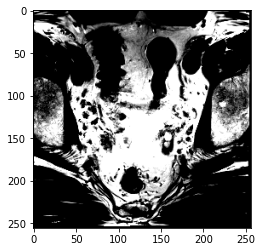

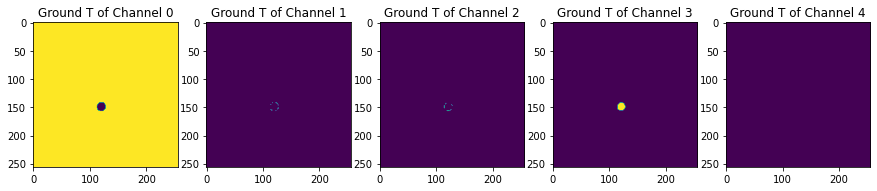

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3) (1, 256, 256, 5)
Unique numbers in channel 0 are [0. 1.]
Unique numbers in channel 1 are [0. 1.]
Unique numbers in channel 2 are [0. 1.]
Unique numbers in channel 3 are [0. 1.]
Unique numbers in channel 4 are [0. 1.]


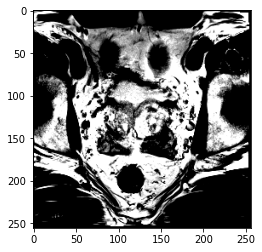

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 256, 256, 3) (1, 256, 256, 5)
Unique numbers in channel 0 are [0. 1.]
Unique numbers in channel 1 are [0. 1.]
Unique numbers in channel 2 are [0. 1.]
Unique numbers in channel 3 are [0. 1.]
Unique numbers in channel 4 are [0.]


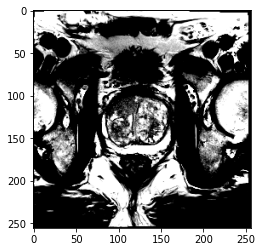

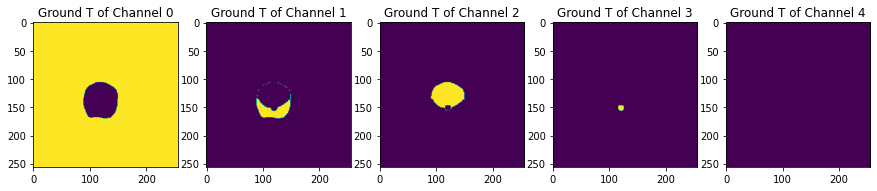

(1, 256, 256, 3) (1, 256, 256, 5)


In [10]:
for example_input, example_target in train_dataset.take(3):
    show_img(example_input, example_target, 5)
    print(example_input.shape, example_target.shape)


## Build the Generator

   * The architecture of generator is a modified U-Net.
   * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
   * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
   * There are skip connections between the encoder and decoder (as in U-Net).


In [11]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
               tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
               kernel_initializer=initializer, use_bias=False)
               )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [12]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
               tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
               padding='same',
               kernel_initializer=initializer,
               use_bias=False)
               )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [13]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
                    downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
                    downsample(128, 4),  # (bs, 64, 64, 128)
                    downsample(256, 4),  # (bs, 32, 32, 256)
                    downsample(512, 4),  # (bs, 16, 16, 512)
                    downsample(512, 4),  # (bs, 8, 8, 512)
                    downsample(512, 4),  # (bs, 4, 4, 512)
                    downsample(512, 4),  # (bs, 2, 2, 512)
                    downsample(512, 4),  # (bs, 1, 1, 512)
                  ]

    up_stack = [
                    upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
                    upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
                    upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
                    upsample(512, 4),  # (bs, 16, 16, 1024)
                    upsample(256, 4),  # (bs, 32, 32, 512)
                    upsample(128, 4),  # (bs, 64, 64, 256)
                    upsample(64, 4),  # (bs, 128, 128, 128)
                ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(NUM_CLASSES, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')  # (bs, 256, 256, OUTPUT_CHANNELS)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [14]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


(1, 256, 256, 5)


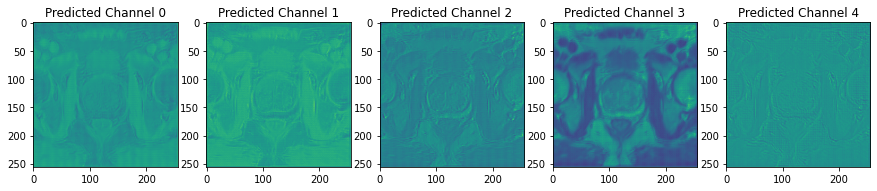

In [15]:
gen_output = generator(example_input, training=False)
fig, axs = plt.subplots(1, NUM_CLASSES, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(NUM_CLASSES):
        axs[i].imshow(gen_output[0,:,:,i])
        axs[i].set_title('Predicted Channel ' + str(i))
print(gen_output.shape)


## Generator loss

   * It is a sigmoid cross entropy loss of the generated images and an array of ones.
   * The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
   * This allows the generated image to become structurally similar to the target image.
   * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.

The training procedure for the generator is shown below:

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [17]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

## Build the Discriminator

   * The Discriminator is a PatchGAN.
   * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
   * The shape of the output after the last layer is (batch_size, 30, 30, 1)
   * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
   * Discriminator receives 2 inputs.
      * Input image and the target image, which it should classify as real.
      * Input image and the generated image (output of generator), which it should classify as fake.
      * Concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))


In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, NUM_CLASSES], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, OUTPUT_CHANNELS + 3)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


In [19]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [20]:
disc_out = discriminator([example_input, gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-.2, vmax=.2, cmap='RdBu_r')
plt.colorbar()


## Discriminator loss

   * The discriminator loss function takes 2 inputs; real images, generated images
   * real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)
   * generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)
   * Then the total_loss is the sum of real_loss and the generated_loss


In [21]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

## Define the Optimizers and Checkpoint-saver

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [23]:
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [24]:
os.getcwd() 

'/storage/ziaeea21/projects/Prostate_Segmentation/Pix2Pix'

In [25]:
checkpoint_prefix 

'./training_checkpoints/ckpt'

## Generate Images

Write a function to plot some images during training.

   * Pass images from the validation dataset to the generator.
   * The generator will then translate the input image into the output.
   * Last step is to plot the predictions and voila!


In [26]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'GroundT of Channel ', 'Predicted Channel ']

    plt.imshow(display_list[0])
    fig, axs = plt.subplots(1,NUM_CLASSES, figsize=(15, 6), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(NUM_CLASSES):
        axs[i].imshow(display_list[1][:,:,i])
        axs[i].set_title(title[1] + str(i))
        
    fig, axs = plt.subplots(1,NUM_CLASSES, figsize=(15, 6), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    for i in range(NUM_CLASSES):
        axs[i].imshow(display_list[2][:,:,i])
        axs[i].set_title(title[2] + str(i))
 
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


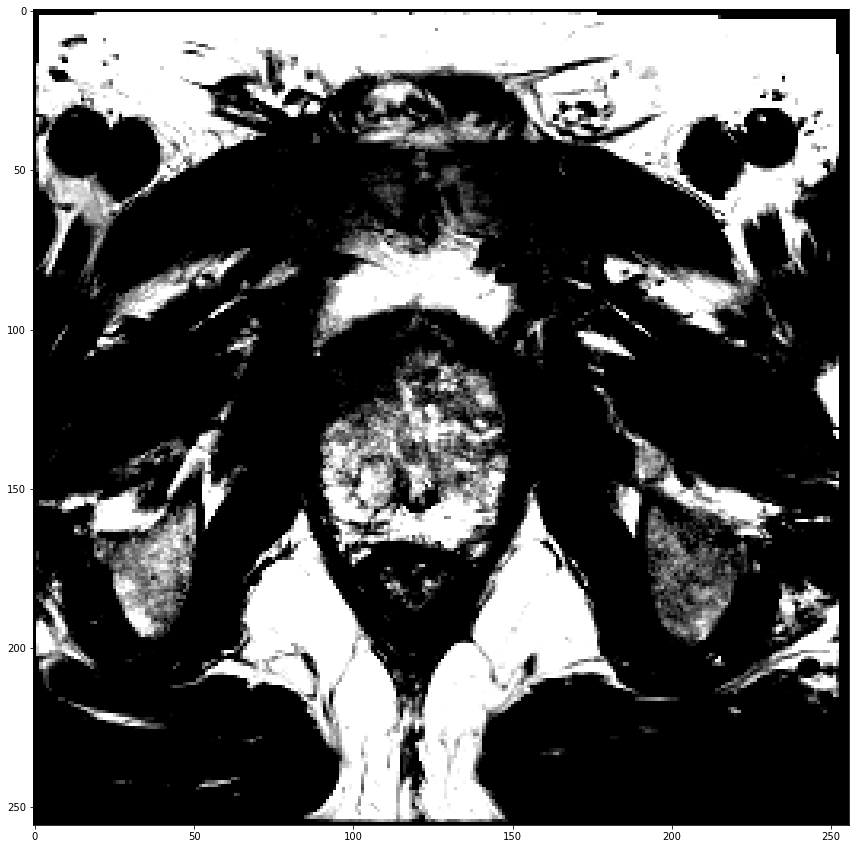

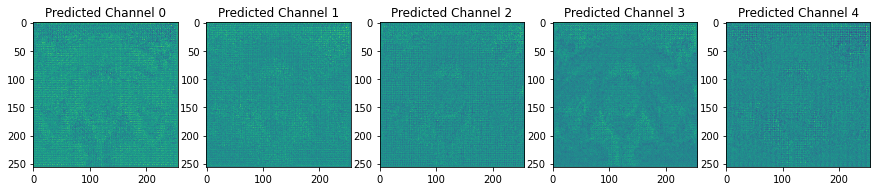

In [27]:
for example_input, example_target in train_dataset.take(1):
    generate_images(generator, example_input, example_target)


## Training

   * For each example input generate an output.
   * The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
   * Next, calculate the generator and the discriminator loss.
   * Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
   * Then log the losses to TensorBoard.


In [28]:

summary_writer = tf.summary.create_file_writer(
                                                log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                                               )

In [29]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)


## The actual training loop:

   * Iterates over the number of epochs.
   * On each epoch it clears the display, and runs generate_images to show it's progress.
   * On each epoch it iterates over the training dataset, printing a '.' for each example.
   * It saves a checkpoint every 20 epochs.


In [30]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        #display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)
            #time.sleep(5)
        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
    checkpoint.save(file_prefix=checkpoint_prefix)


In [32]:
#ssh -L 16007:127.0.0.1:16007 ziaeea21@dgx1-em1.vda.univie.ac.at
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --port=16007


Reusing TensorBoard on port 16007 (pid 1861177), started 0:00:14 ago. (Use '!kill 1861177' to kill it.)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  0
...................
Time taken for epoch 1 is 21.413130044937134 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  1
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 2 is 2.4281973838806152 sec


Epoch:  2
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 3 is 2.314021587371826 sec


Epoch:  3
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 4 is 2.3606443405151367 sec


Epoch:  4
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 5 is 2.5682685375213623 sec


Epoch:  5
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 6 is 2.441843032836914 sec



/storage/ziaeea21/conda_envs/Prostate_Segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Epoch:  6
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 7 is 2.340282678604126 sec


Epoch:  7
...................
Time taken for epoch 8 is 2.3848984241485596 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  8
...................
Time taken for epoch 9 is 2.231508255004883 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  9
...................


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Time taken for epoch 10 is 9.738903284072876 sec


Epoch:  10
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 11 is 2.591627359390259 sec


Epoch:  11
...................
Time taken for epoch 12 is 2.334071159362793 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  12
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 13 is 2.526798963546753 sec


Epoch:  13
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 14 is 2.345237970352173 sec


Epoch:  14
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 15 is 2.3935627937316895 sec


Epoch:  15
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 16 is 2.7178385257720947 sec


Epoch:  16
...................
Time taken for epoch 17 is 2.250528335571289 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  17
...................
Time taken for epoch 18 is 2.263827085494995 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Epoch:  18
...................

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Time taken for epoch 19 is 2.3087174892425537 sec


Epoch:  19
...................
Time taken for epoch 20 is 9.906054735183716 sec



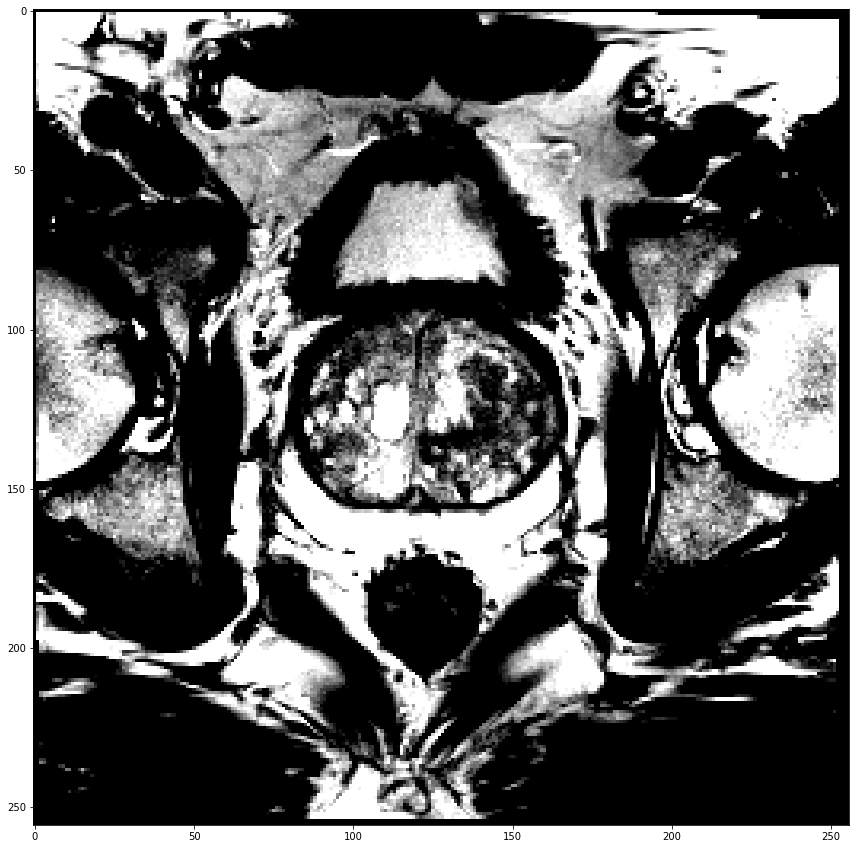

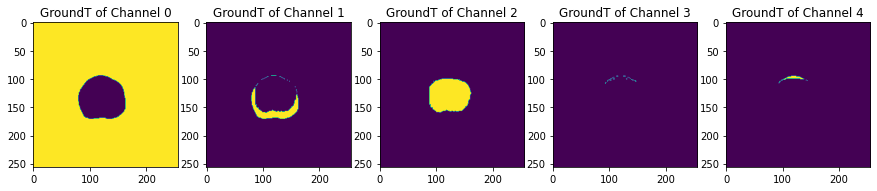

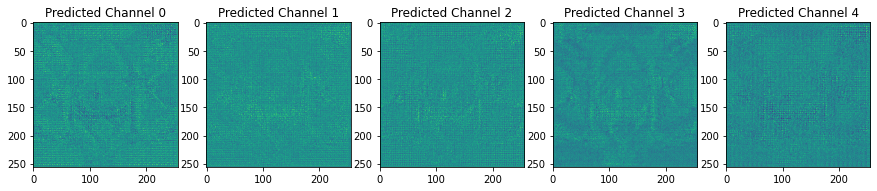

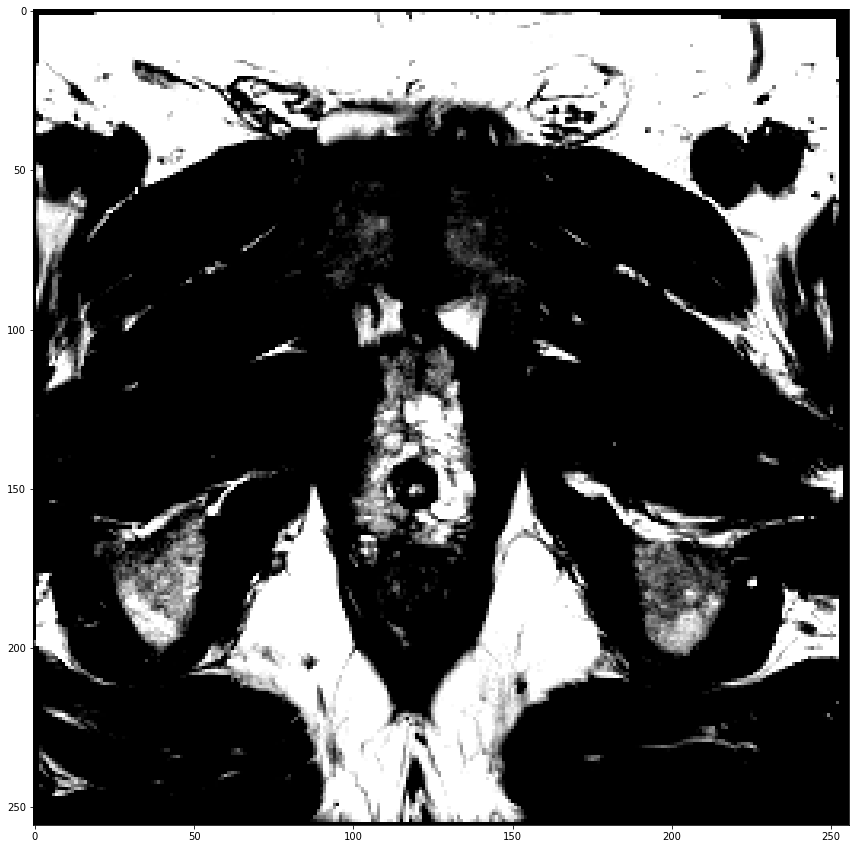

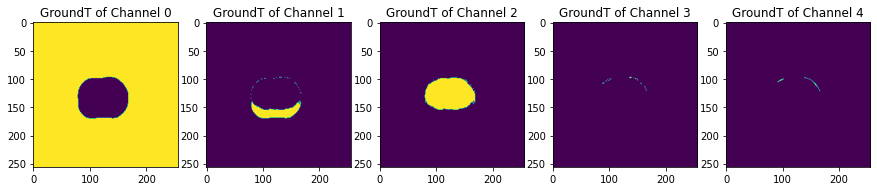

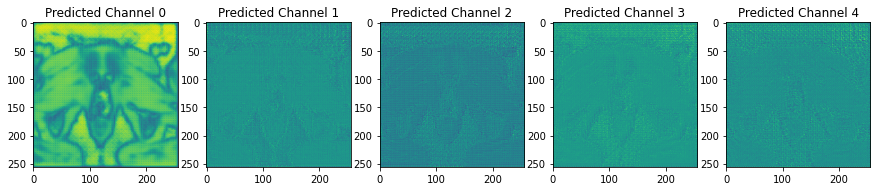

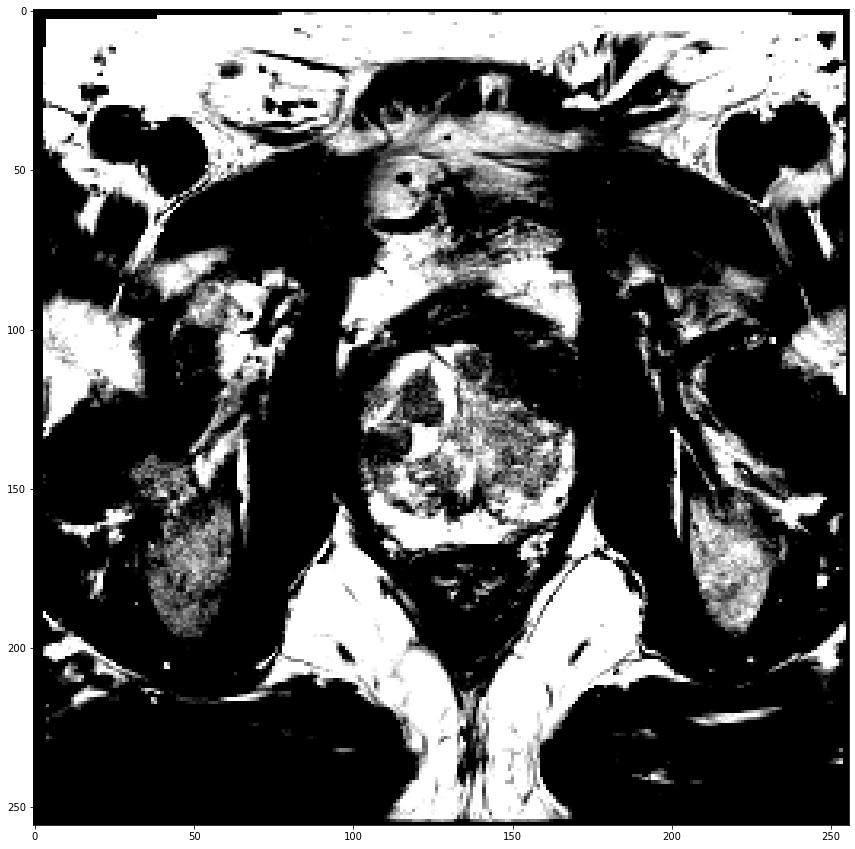

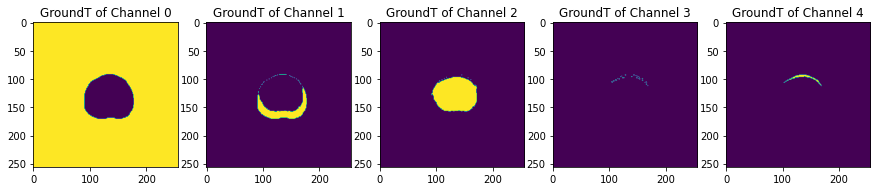

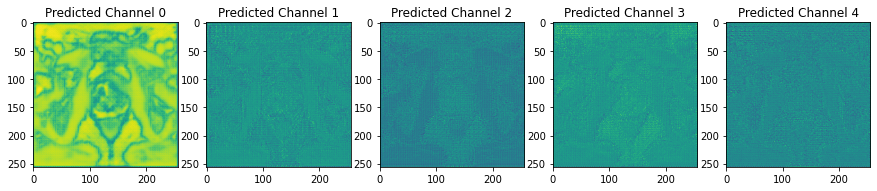

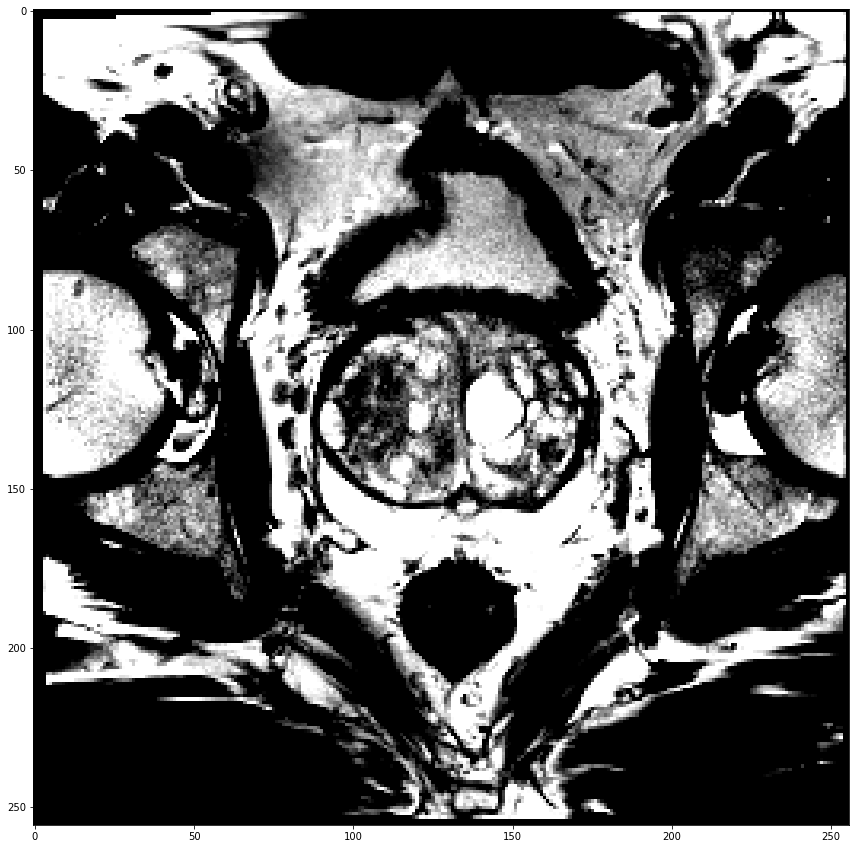

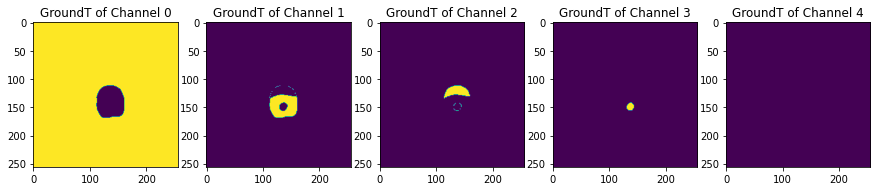

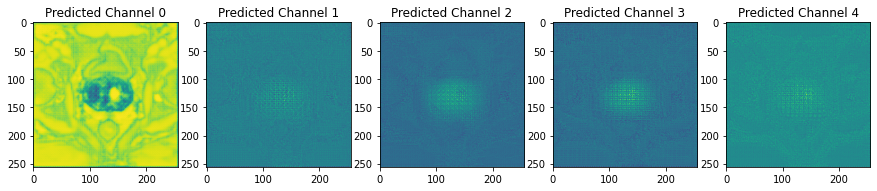

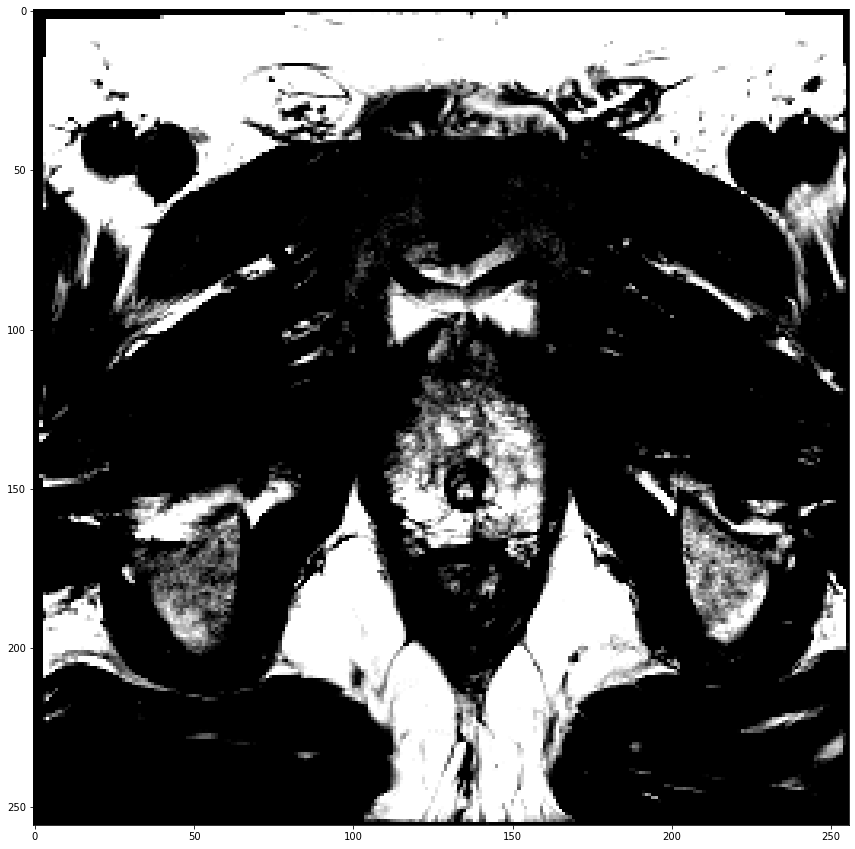

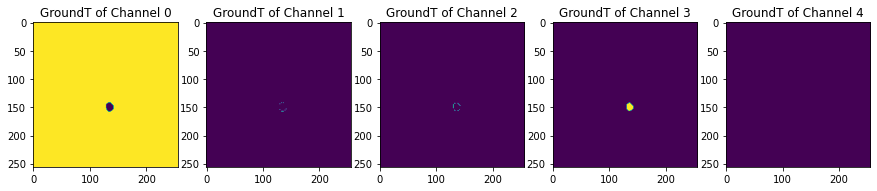

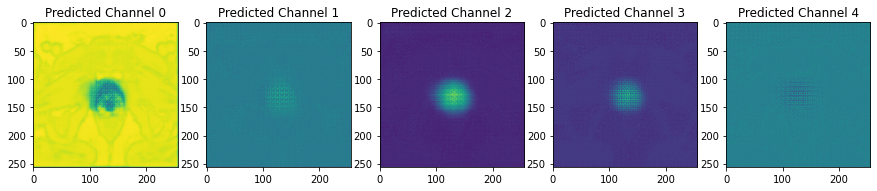

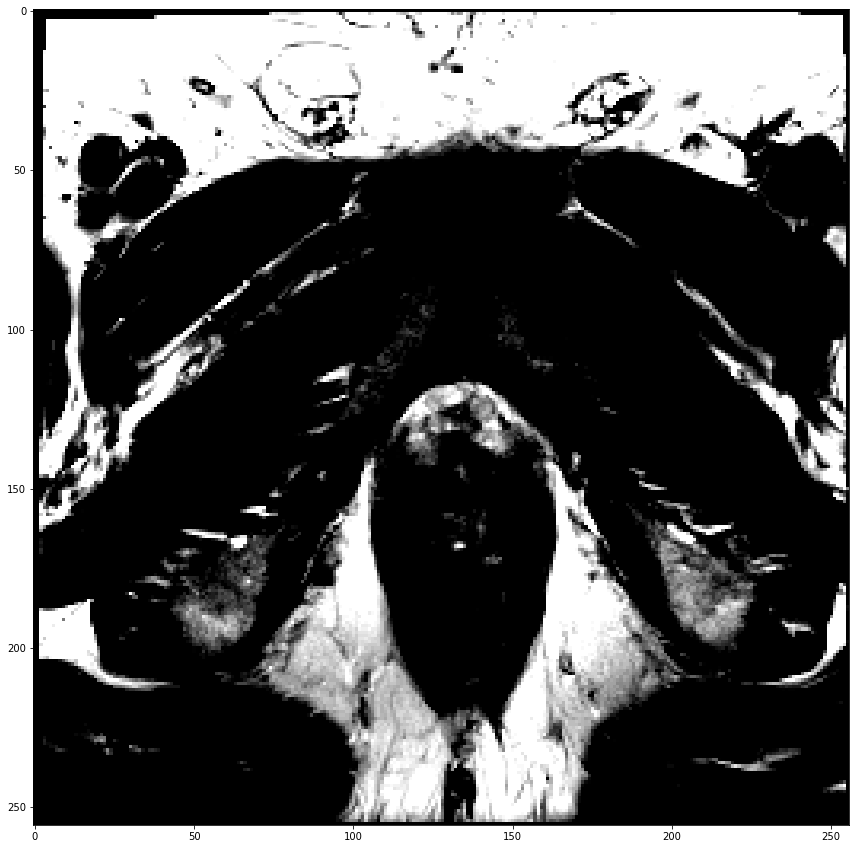

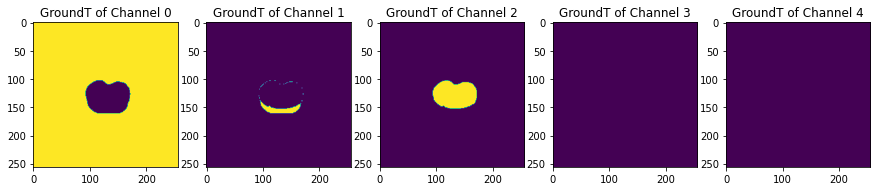

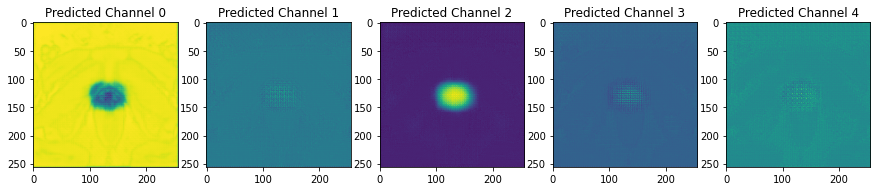

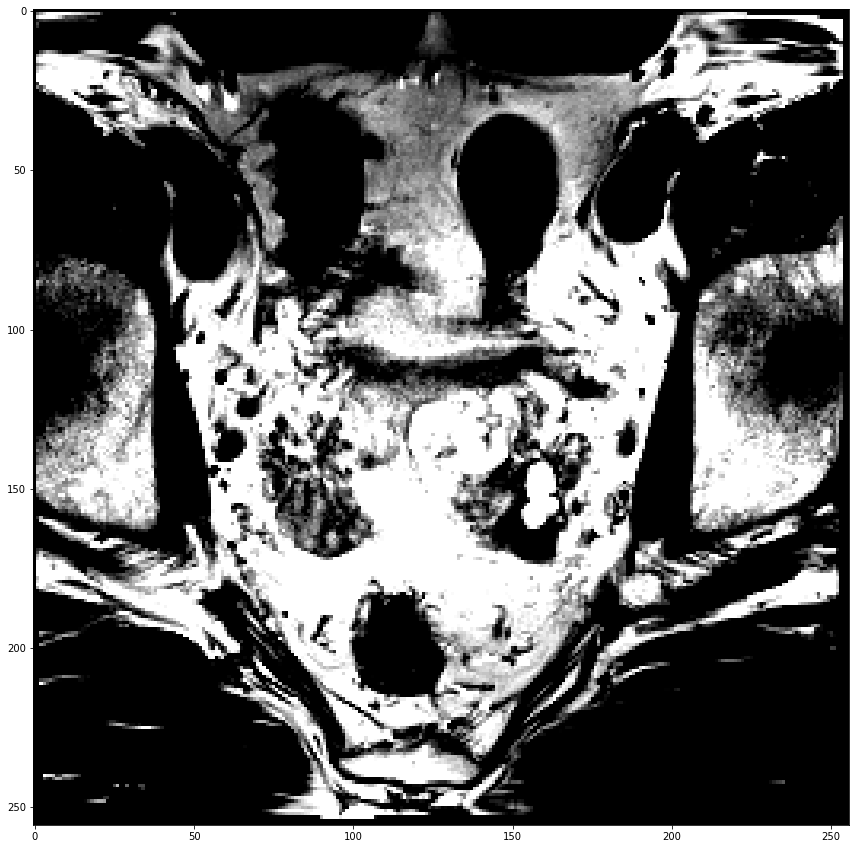

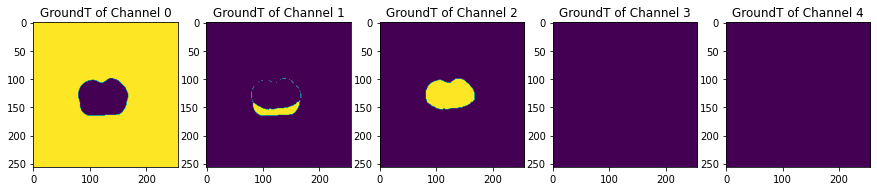

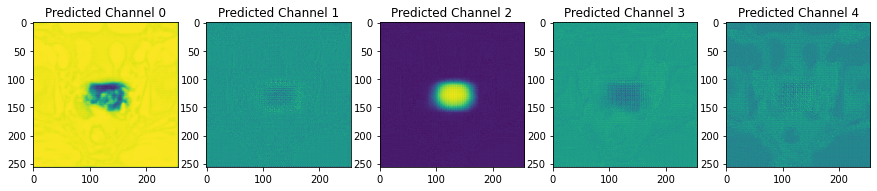

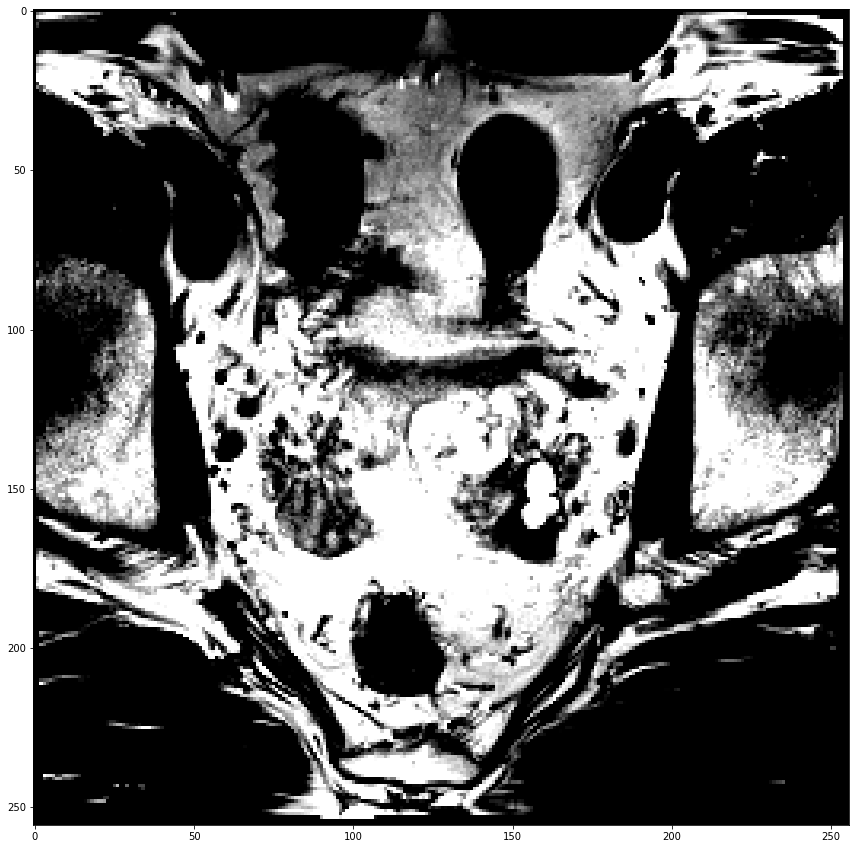

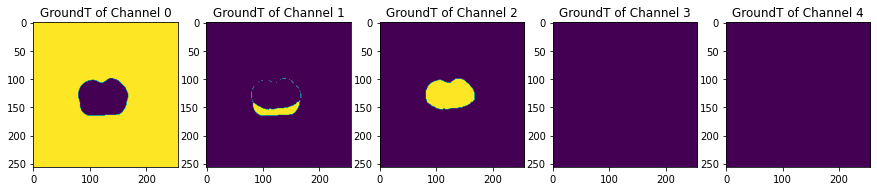

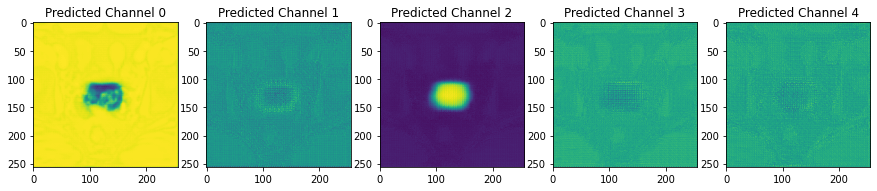

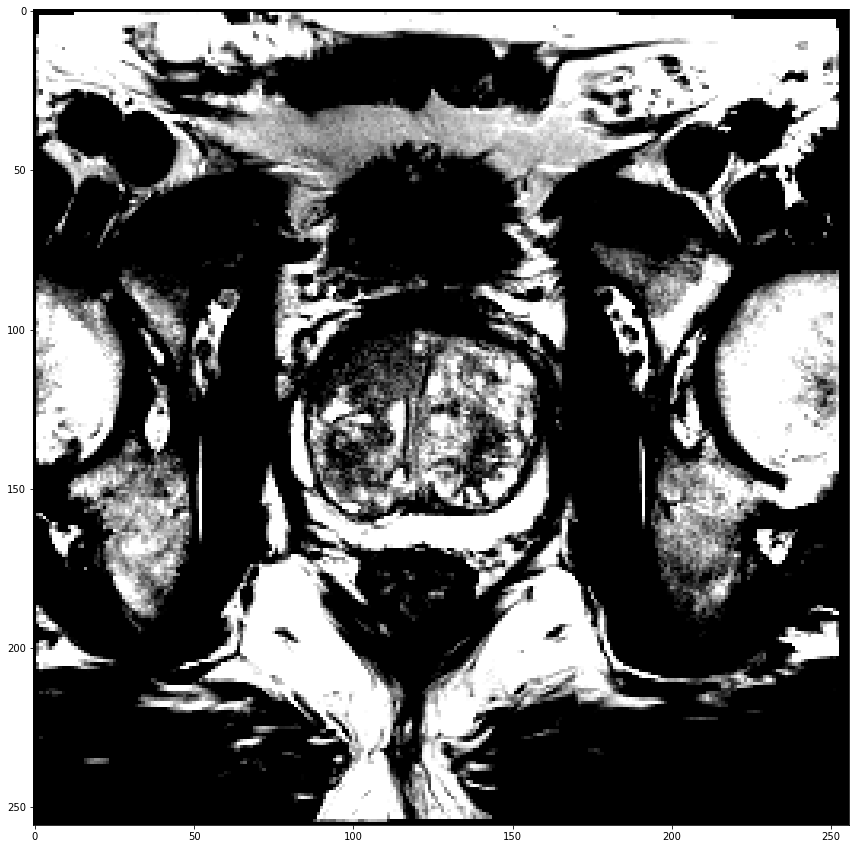

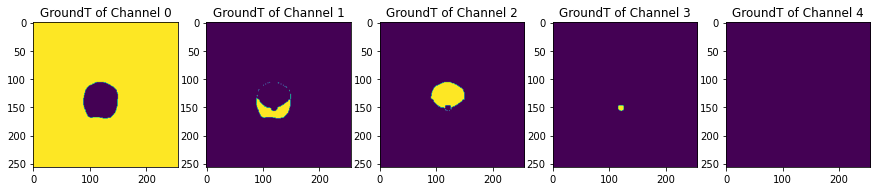

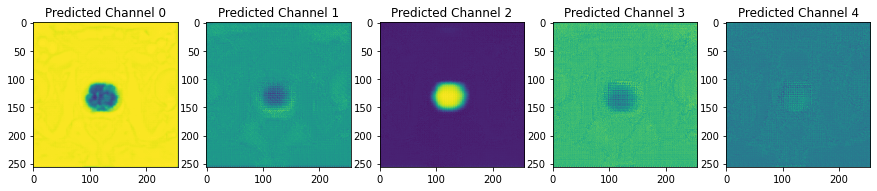

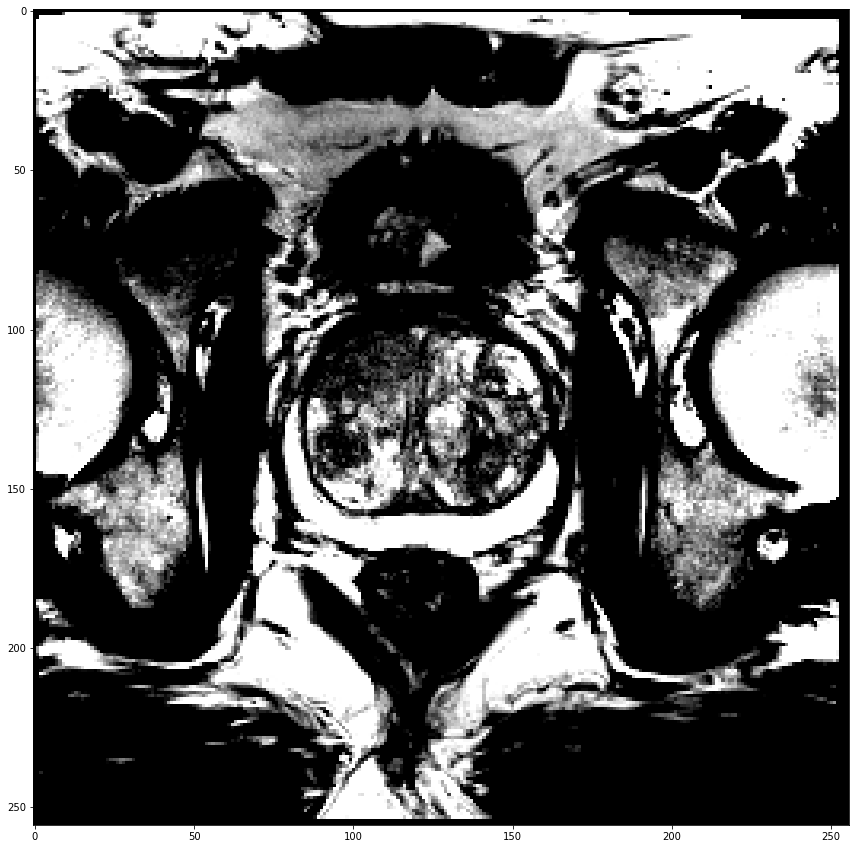

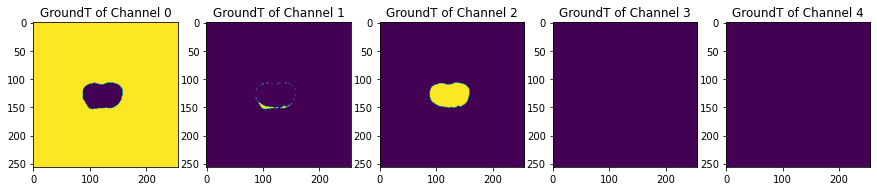

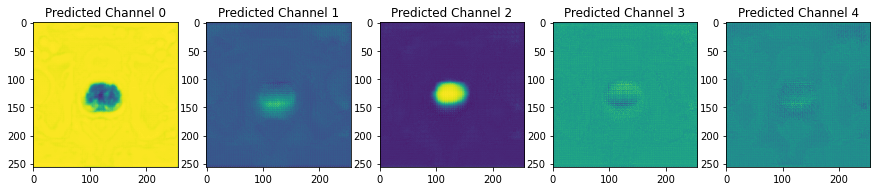

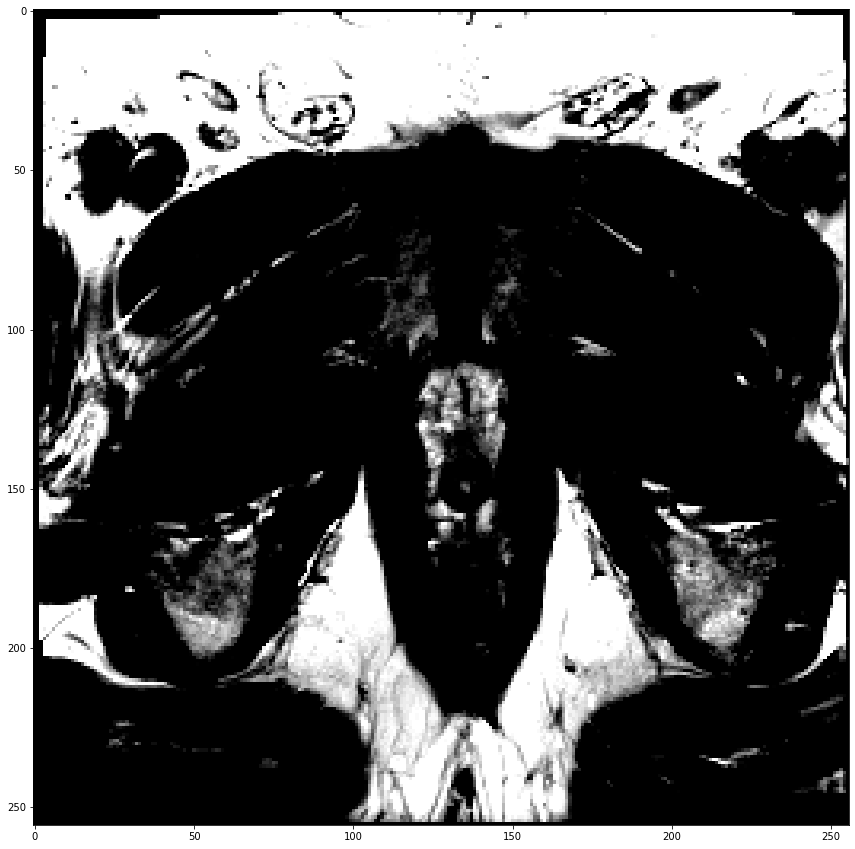

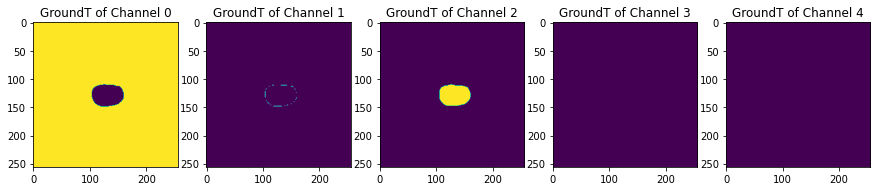

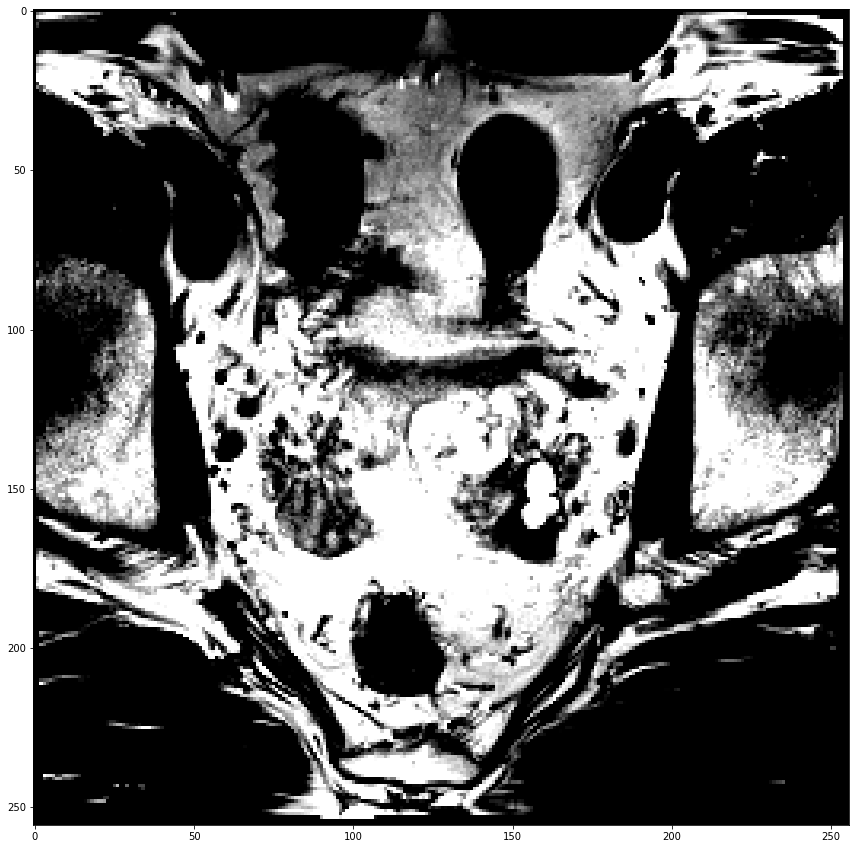

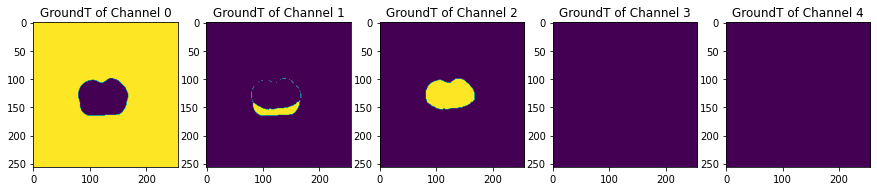

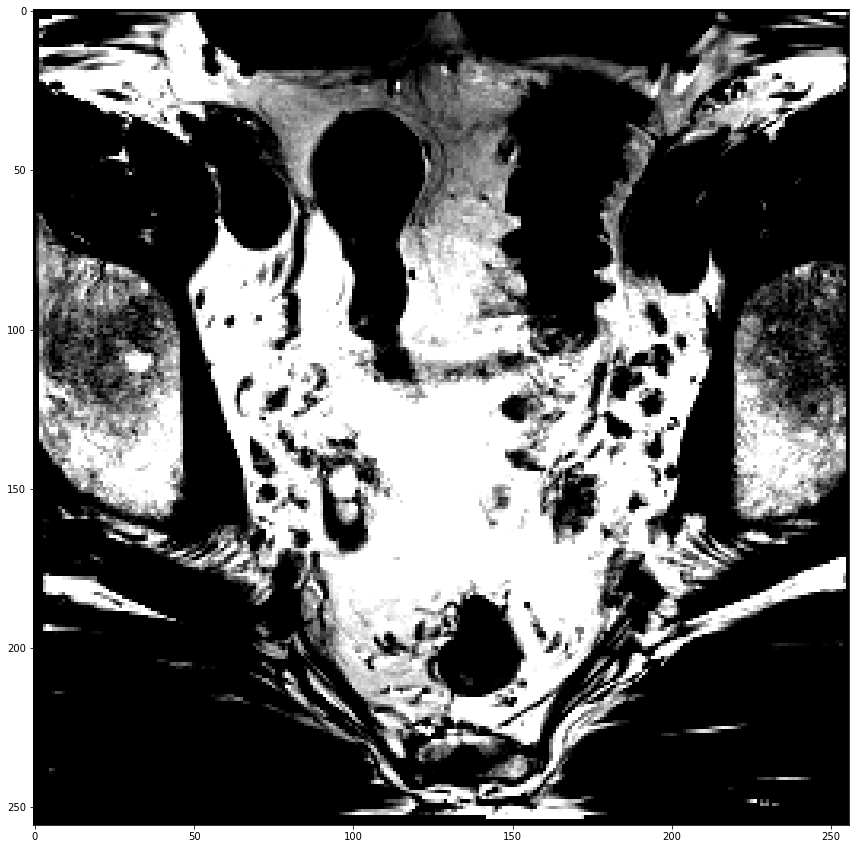

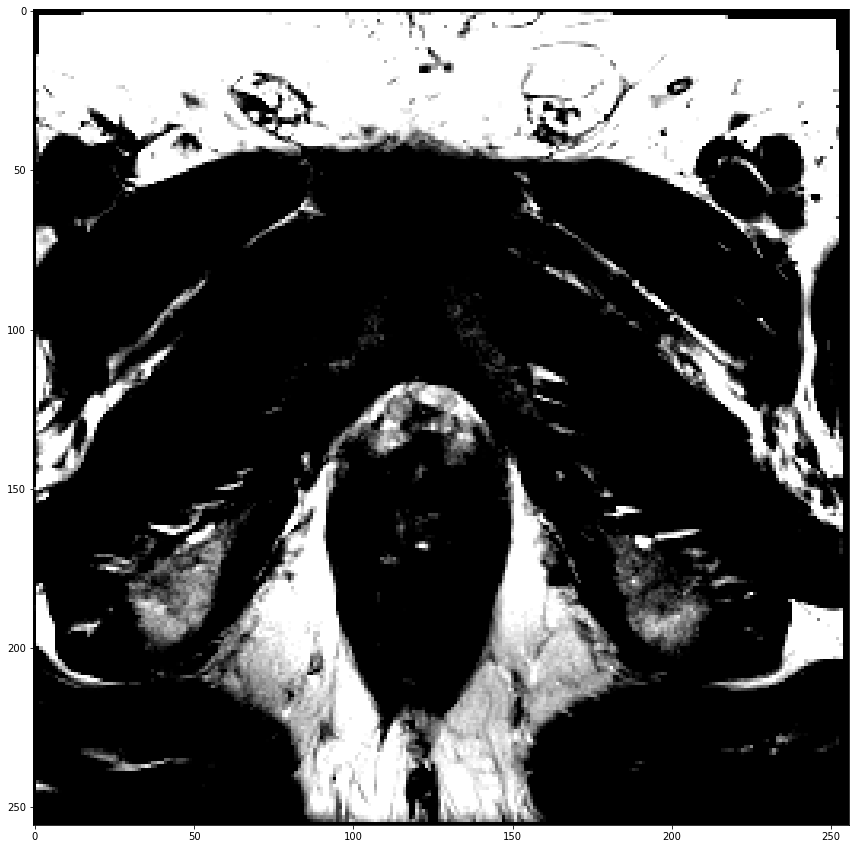

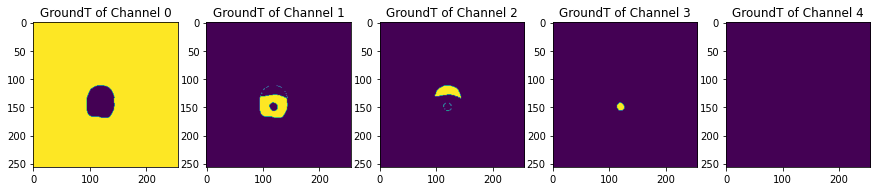

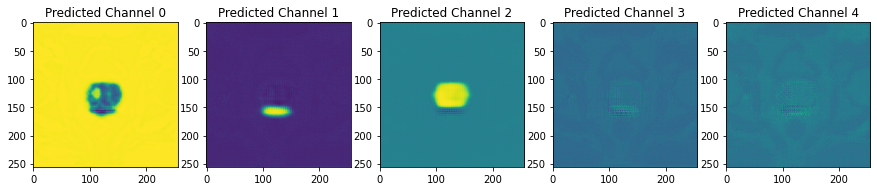

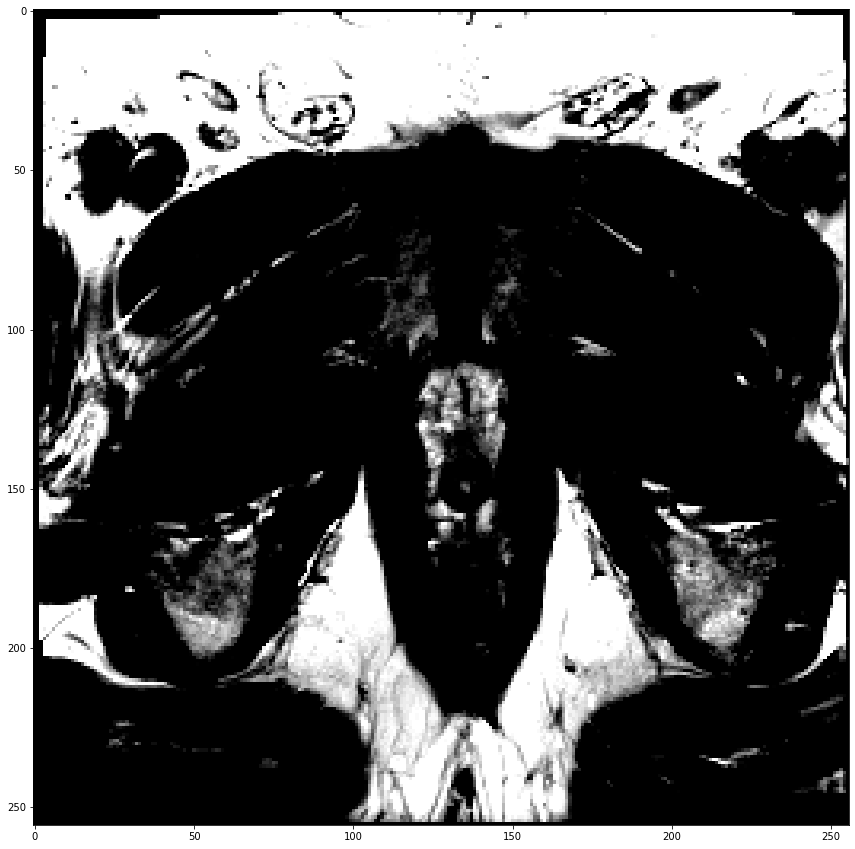

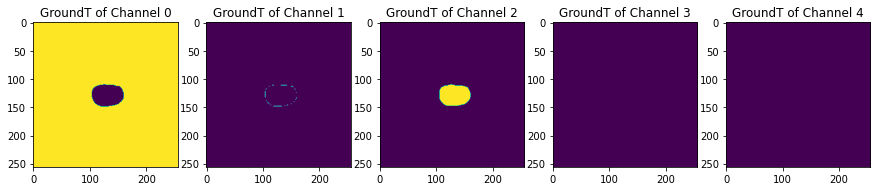

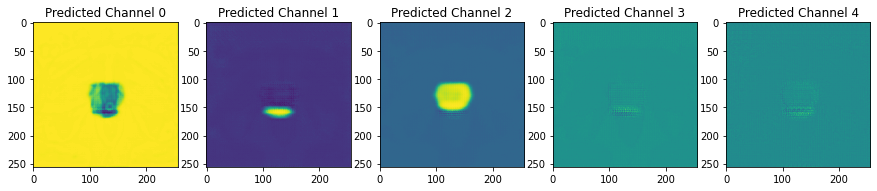

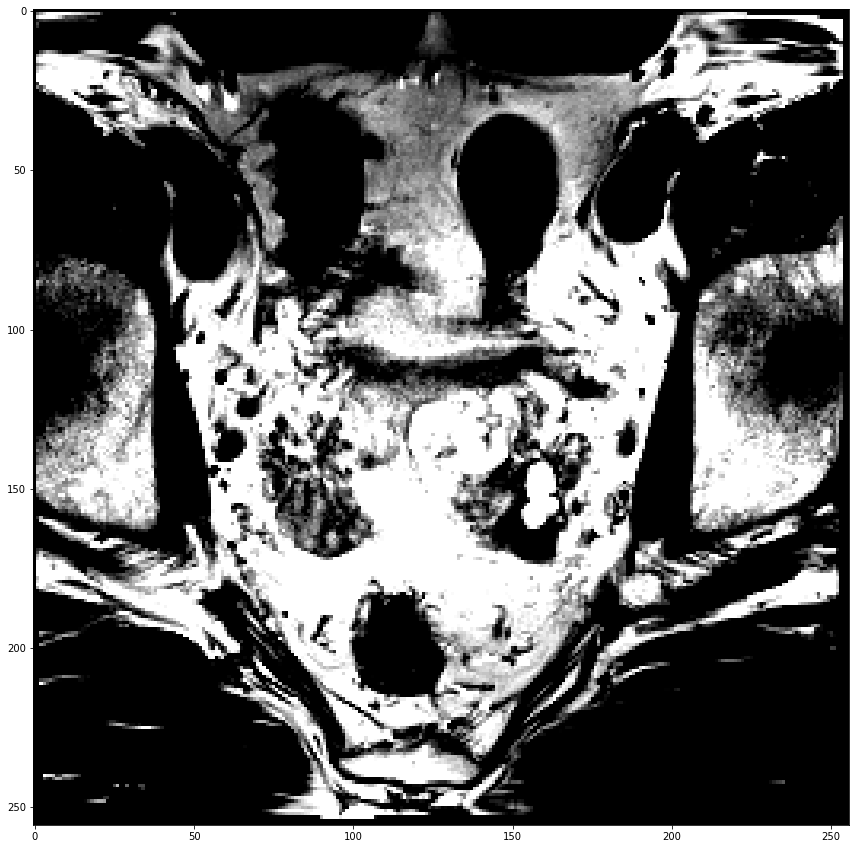

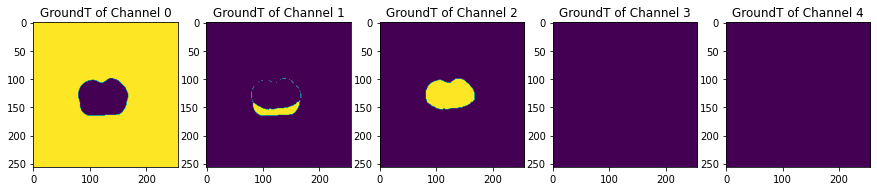

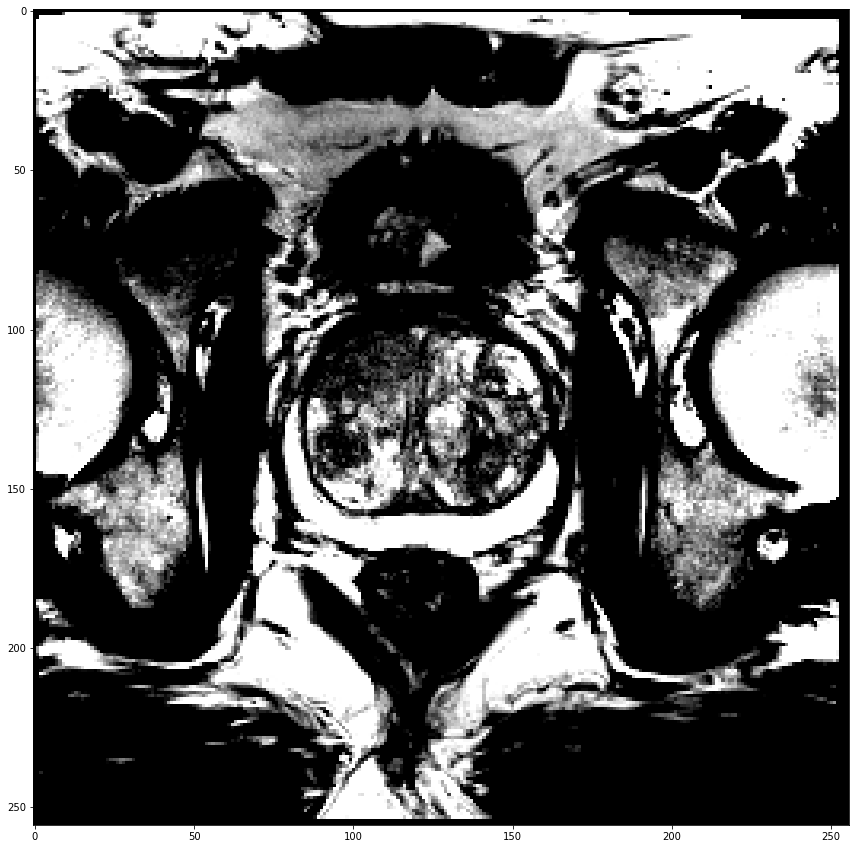

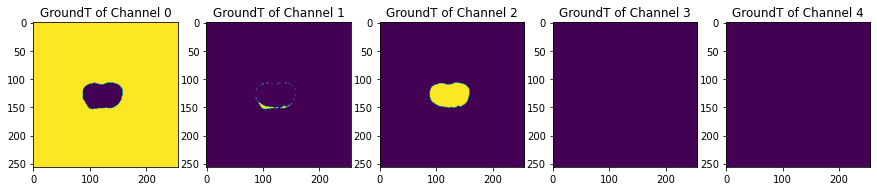

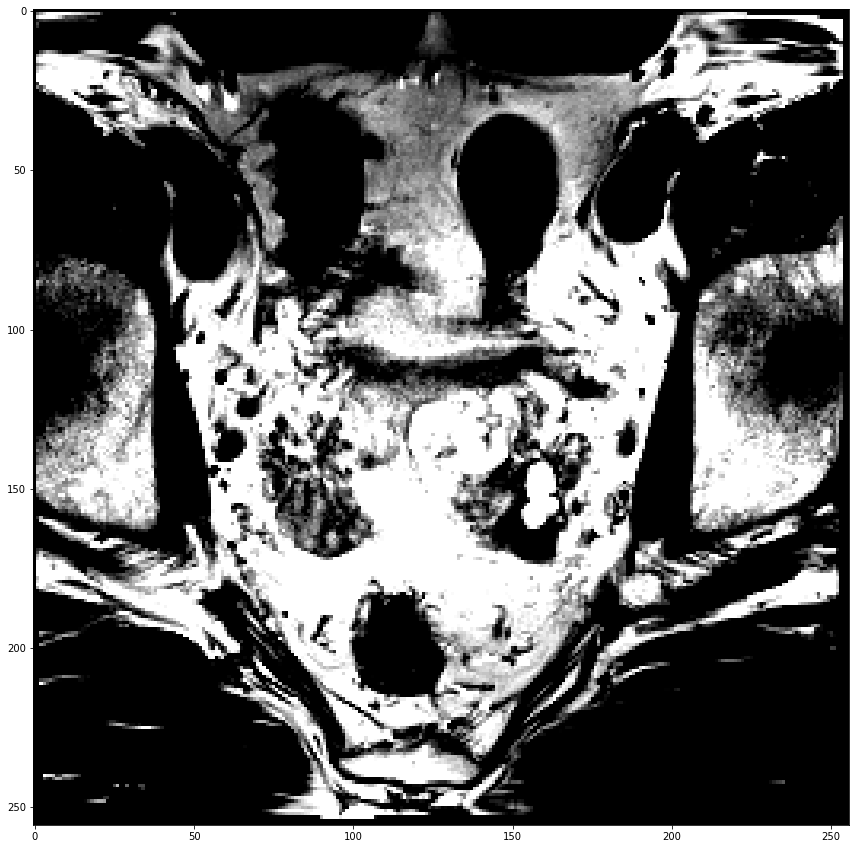

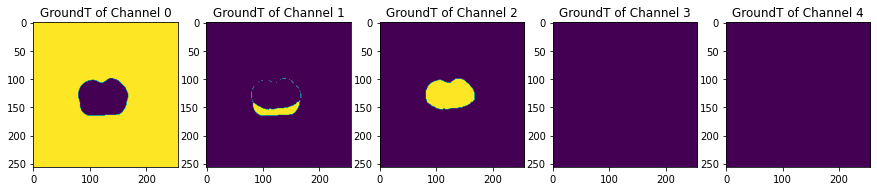

In [33]:
fit(train_dataset, EPOCHS, train_dataset)
